In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import requests, json, math
import matplotlib.pyplot as plt
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from census import Census
from us import states
from shapely.geometry import Point, MultiPoint, Polygon, LineString
from shapely.ops import nearest_points
from IPython.display import clear_output
%matplotlib inline

In [2]:
census_api_key='50eb4e527e6c123fc8230117b3b526e1055ee8da'
nominatim=Nominatim()
overpass=Overpass()
c=Census(census_api_key)

In [3]:
ada={'state':'ID','county':'001','name':'Ada County, ID'}
king={'state':'WA','county':'033','name':'King County, WA'}
housing_tables={'pre_39':'B25034_011E',
                '1940-1949':'B25034_010E',
               '1950-1959':'B25034_009E',
               '1960-1969':'B25034_008E',
               '1970-1979':'B25034_007E',
               '1980-1989':'B25034_006E',
               '1990-1999':'B25034_005E',
               '2000-2009':'B25034_004E'}

In [4]:
def get_county_tracts(state, county_code):
    state_shapefile=gpd.read_file(states.lookup(state).shapefile_urls('tract'))
    county_shapefile=state_shapefile.loc[state_shapefile['COUNTYFP10']==county_code]
    return county_shapefile.to_crs('EPSG:3857')

In [5]:
def get_tract_population(state, county_code):
    population=pd.DataFrame(c.acs5.state_county_tract( 'B01003_001E', states.lookup(state).fips,'{}'.format(county_code),Census.ALL))
    population.rename(columns={'B01003_001E':'Total Population'}, inplace=True)
    population=population.loc[population['Total Population']!=0]
    return population

In [24]:
def geometrize_census_table_tracts(state,county_code,table,densityColumn=None,left_on='TRACTCE10',right_on='tract'):
    tracts=get_county_tracts(state, county_code)
    geometrized_tracts=tracts.merge(table,left_on=left_on,right_on=right_on)
    if densityColumn:
        geometrized_tracts['Density']=geometrized_tracts[densityColumn]/(geometrized_tracts['ALAND10']/2589988.1103)
    return geometrized_tracts

In [7]:
def get_housing_age_diversity(state,county):
    cols=list(housing_tables.keys())
    cols.insert(0,'TRACTCE10')
    cols.insert(1,'geometry')
    out=get_county_tracts(state,county)
    for key, value in housing_tables.items():
        out=out.merge(pd.DataFrame(c.acs5.state_county_tract(value,states.lookup(state).fips,county,Census.ALL)),left_on='TRACTCE10',right_on='tract')
        out.rename(columns={value:key},inplace=True)
    out=out[cols]
    out['Standard Deviation']=out.std(axis=1)
    return out

In [8]:
def osm_way_to_polygon(way):
    points=list()
    for p in range(len(way)):
        point=Point(way[p]['lon'],way[p]['lat'])
        points.append(point)
    poly=Polygon([[p.x, p.y] for p in points])
    return poly

In [9]:
def query_osm(location,feature_type,feature_name=None,crs='EPSG:3857'):
    osm_id=nominatim.query(location).areaId()
    if feature_name:
        query_points=overpassQueryBuilder(area=osm_id,
                                   elementType='node',
                                   selector='"{ft}"="{fn}"'.format(ft=feature_type,fn=feature_name),
                                   out='body',
                                   includeGeometry=True)
        query_polys=overpassQueryBuilder(area=osm_id,
                                   elementType='way',
                                   selector='"{ft}"="{fn}"'.format(ft=feature_type,fn=feature_name),
                                   out='body',
                                   includeGeometry=True)
    else:
        query_points=overpassQueryBuilder(area=osm_id,
                                   elementType='node',
                                   selector='"{ft}"'.format(ft=feature_type),
                                   out='body',
                                   includeGeometry=True)
        query_polys=overpassQueryBuilder(area=osm_id,
                                   elementType='way',
                                   selector='"{ft}"'.format(ft=feature_type,fn=feature_name),
                                   out='body',
                                   includeGeometry=True)
    if len(overpass.query(query_points).toJSON()['elements'])>0:
        points=overpass.query(query_points).toJSON()['elements']
        points=pd.DataFrame(points)
        points=gpd.GeoDataFrame(points,geometry=gpd.points_from_xy(points['lon'],points['lat']),crs='epsg:4326')
        points=points.to_crs(crs)
    else:
        points=pd.DataFrame()
    if len(overpass.query(query_polys).toJSON()['elements'])>0:
        polys=overpass.query(query_polys).toJSON()['elements']
        polys=pd.DataFrame(polys)
        poly_geo=list()
        for i in polys.geometry:
            geo=osm_way_to_polygon(i)
            poly_geo.append(geo)
        polys.geometry=poly_geo
        polys=gpd.GeoDataFrame(polys,crs='epsg:4326')
        polys=polys.to_crs(crs)
        polys.geometry=polys.geometry.centroid
    else:
        polys=pd.DataFrame()
    gdf=pd.concat([points,polys])
    gdf=pd.concat([gdf.drop(['tags'],axis=1),gdf['tags'].apply(pd.Series)],axis=1)
    gdf=gpd.GeoDataFrame(gdf[['geometry','name','id']])
    return gdf

In [10]:
def get_key_features(name):
    df=query_osm(name,'office')
    df=pd.concat([df,query_osm(name,'leisure','park')])
    amenities=['bar','restaurant','cafe','pub','library','school','bank','clinic','hospital','pharmacy','post_office']
    shops=['supermarket','hardware']
    for a in amenities:
        df=pd.concat([df,query_osm(name,'amenity',a)])
    for s in shops:
        df=pd.concat([df,query_osm(name,'shop',s)])
    return gpd.GeoDataFrame(df)

In [11]:
def create_point_grid(poly,nrows=100,ncols=100,crs='EPSG:3857'):
    cols=np.linspace(poly.total_bounds[0],poly.total_bounds[2],ncols)
    rows=np.linspace(poly.total_bounds[1],poly.total_bounds[3],nrows)
    points=[]
    for x in cols:
        for y in rows:
            points.append(Point(x,y))
    grid=gpd.GeoDataFrame({'geometry':points},crs=crs)
    grid=gpd.overlay(grid,poly,how='intersection')
    return grid

In [12]:
def get_nearby_features(grid,location,feature_type,output_name,feature_name=None,nearby_distance=.5,crs='EPSG:3857'):
    grid=grid.to_crs(crs)
    dests=query_osm(location,feature_type,feature_name).to_crs(crs)
    colname='nearby_{}'.format(output_name)
    out=gpd.GeoDataFrame()
    i=1
    for index, row in grid.iterrows():
        clear_output(wait=True)
        point = row.geometry
        q,n = nearest_points(point,dests.geometry.unary_union)
        row['points']=len(grid.loc[grid['TRACTCE10']==row['TRACTCE10']])
        if (point.distance(n)/1609.341)<nearby_distance:
            row['nearby']=True
        else:
            row['nearby']=False
        out=out.append(row)
        print('calculating {}, {}% complete'.format(output_name,round(((i/len(grid))*100),1)))
        i+=1
    out=out.groupby('TRACTCE10',as_index=False).apply(lambda x: x['nearby'].sum()/len(x))
    out.columns=['TRACTCE10',colname]
    return out

In [13]:
def score_streets(gdf):
    out=gpd.GeoDataFrame()
    i=1
    for index, row in gdf.iterrows():
        clear_output(wait=True)
        g=ox.graph_from_polygon(row['geometry'],network_type='walk')
        stats=ox.stats.basic_stats(g)
        row['street_score']=stats['street_length_avg']/stats['streets_per_node_avg']
        print('{}% complete'.format(round(((i/len(gdf))*100),2)))
        ox.plot_graph(g,node_size=0)
        out=out.append(row)
        i+=1
    return out

In [14]:
def calculate_nearbyness(grid,location):
    print('calcualting offices')
    nearby_df=get_nearby_features(grid,location,'office','offices')
    print('calculating parks')
    nearby_df=nearby_df.merge(get_nearby_features(grid,location='Ada County',feature_type='leisure',feature_name='park',output_name='parks'))
    amenities=['bar','restaurant','cafe','pub','library','school','bank','clinic','hospital','pharmacy','post_office']
    shops=['supermarket','hardware','doityourself']
    for a in amenities:
        nearby_df=nearby_df.merge(get_nearby_features(grid,location='Ada County',feature_type='amenity',feature_name=a,output_name=a))
    for s in shops:
        nearby_df=nearby_df.merge(get_nearby_features(grid,location='Ada County',feature_type='shop',feature_name=s,output_name=s))
    nearby_df['nearbyness']=nearby_df.mean(axis=1)
    return nearby_df

<AxesSubplot:>

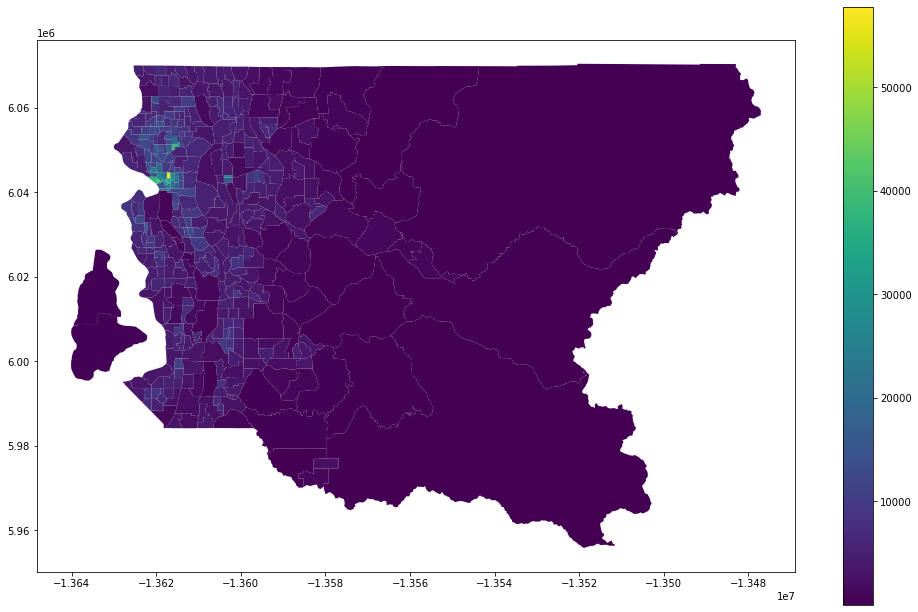

In [15]:
king_pop_tracts=geometrize_census_table_tracts(king['state'],king['county'],get_tract_population(king['state'],king['county']),'Total Population')
king_pop_tracts.plot(column='Density',legend=True,figsize=(17,11))

<AxesSubplot:>

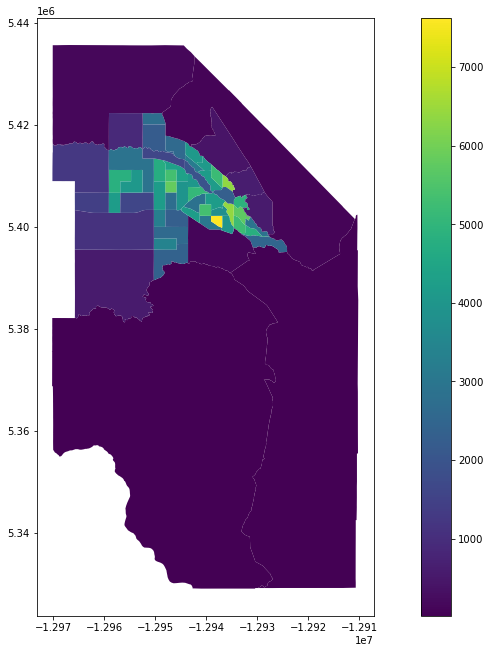

In [16]:
ada_pop_tracts=geometrize_census_table_tracts(ada['state'],ada['county'],get_tract_population(ada['state'],ada['county']),'Total Population')
ada_pop_tracts.plot(column='Density',legend=True,figsize=(17,11))

<AxesSubplot:>

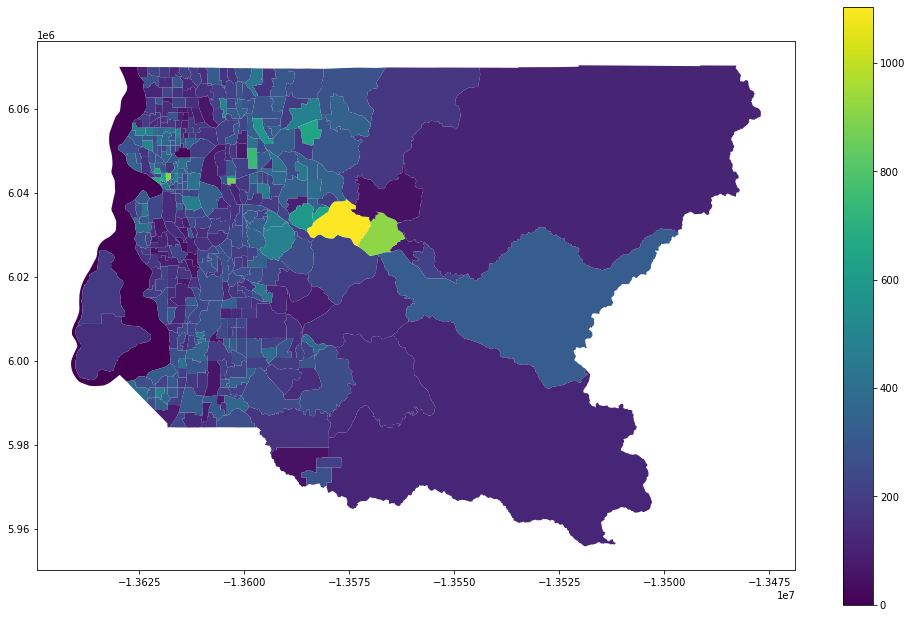

In [17]:
king_housing=get_housing_age_diversity(king['state'],king['county'])
king_housing.plot(column='Standard Deviation',legend=True,figsize=(17,11))

<AxesSubplot:>

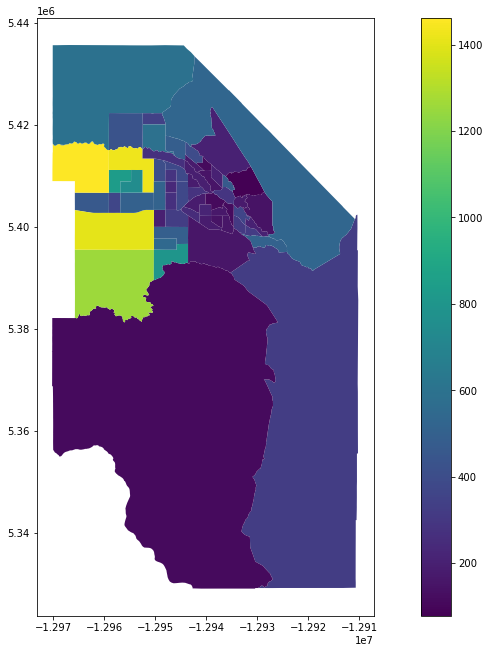

In [18]:
ada_housing=get_housing_age_diversity(ada['state'],ada['county'])
ada_housing.plot(column='Standard Deviation',legend=True,figsize=(17,11))

In [19]:
king_grid=create_point_grid(get_county_tracts(king['state'],king['county']),200,200)

In [20]:
ada_grid=create_point_grid(get_county_tracts(ada['state'],ada['county']),200,200)

In [21]:
king_nearby=calculate_nearbyness(king_grid,king['name'])
king_nearby

calculating doityourself, 100.0% complete


,TRACTCE10,nearby_offices,nearby_parks,nearby_bar,nearby_restaurant,nearby_cafe,nearby_pub,nearby_library,nearby_school,nearby_bank,nearby_clinic,nearby_hospital,nearby_pharmacy,nearby_post_office,nearby_supermarket,nearby_hardware,nearby_doityourself,nearbyness
0,000100,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017857
1,000200,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008929
2,000300,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012500
3,000401,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025000
4,000402,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,032702,0.001247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000078
394,032703,0.234043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014628
395,032704,0.197674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012355
396,032800,0.001679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000105


<AxesSubplot:>

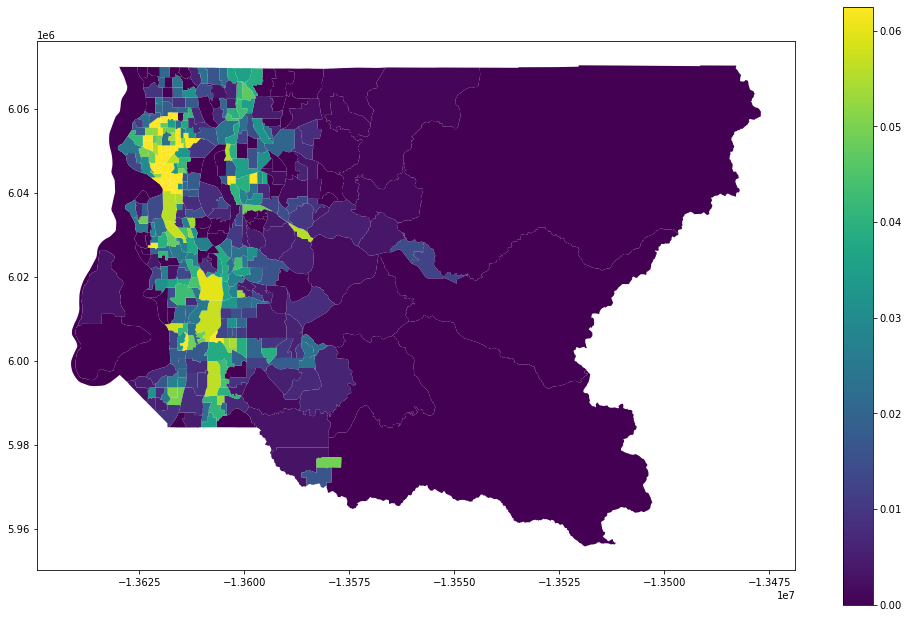

In [30]:
king_nearby_geo=geometrize_census_table_tracts(king['state'],king['county'],king_nearby,right_on='TRACTCE10')
king_nearby_geo.plot(column='nearbyness',legend=True,figsize=(17,11))

In [22]:
ada_nearby=calculate_nearbyness(ada_grid,ada['name'])
ada_nearby

KeyboardInterrupt: 

In [ ]:
ada_street_scores=score_streets(get_county_tracts(ada['state'],ada['county']))
ada_street_scores.plot(column='street_score',legend=True,figsize=(17,11))

In [ ]:
king_street_scores=score_streets(get_county_tracts(king['state'],king['county']))
king_street_scores.plot(column='street_score',legend=True,figsize=(17,11))

In [31]:
king_nearby

,STATEFP10_x,COUNTYFP10_x,TRACTCE10,GEOID10_x,NAME10_x,NAMELSAD10_x,MTFCC10_x,FUNCSTAT10_x,ALAND10_x,AWATER10_x,...,nearby_school,nearby_bank,nearby_clinic,nearby_hospital,nearby_pharmacy,nearby_post_office,nearby_supermarket,nearby_hardware,nearby_doityourself,nearbyness
0,53,033,022006,53033022006,220.06,Census Tract 220.06,G5020,S,1408907,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044643
1,53,033,032320,53033032320,323.20,Census Tract 323.20,G5020,S,9554873,38494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,53,033,031703,53033031703,317.03,Census Tract 317.03,G5020,S,7139218,643846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020270
3,53,033,031206,53033031206,312.06,Census Tract 312.06,G5020,S,3668962,60430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003906
4,53,033,032102,53033032102,321.02,Census Tract 321.02,G5020,S,79040166,84391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,53,033,000900,53033000900,9,Census Tract 9,G5020,S,996458,2531309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007353
394,53,033,022202,53033022202,222.02,Census Tract 222.02,G5020,S,2613884,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833
395,53,033,032323,53033032323,323.23,Census Tract 323.23,G5020,S,3291842,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
396,53,033,021600,53033021600,216,Census Tract 216,G5020,S,2855710,143532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023438
